<center><h1>Step 0 - Preprocessing</h1></center> 

In this section, we first read the data including the bug reports and source code files of all 12 projects and for ease of access, we save them as two pickle files in the ./Data directory. Therefore, this set of code will populate the ./Data directory with "allBugReports.pickle" which is a pandas dataframe that contains all the bug reports from all projects and "allSourceCodes.pickle" which is a pandas dataframe that contains all source files after preprocessing.

### Required Libraries

In [5]:
!pip install javalang

In [86]:
pip install gensim

  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
Note: you may need to restart the kernel to use updated packages.


In [6]:
from __future__ import division
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
import warnings
import javalang
import re
import glob
import math
import time
from scipy import spatial
import scipy.spatial.distance
import xml.etree.ElementTree as ET
import requests
import multiprocessing
from tqdm.notebook import tqdm as tq
from time import gmtime, strftime
from random import randint

# Preprocessing

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem.snowball import SnowballStemmer
import html

import copy

# Method1

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.preprocessing import normalize

# Method2

from sklearn.model_selection import train_test_split

# Method3

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import multiprocessing

# Analysis

import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=FutureWarning)

<center><h1>Splitting code and natural language</h1></center> 

<center><h1>Loading source codes into pandas Dataframe</h1></center> 

In [7]:
def classNames_methodNames(node):
    result=''
    if isinstance(node,javalang.tree.MethodDeclaration) or isinstance(node,javalang.tree.ClassDeclaration):
        return node.name.lower()+' '
    if not (isinstance(node,javalang.tree.PackageDeclaration) or
        isinstance(node,javalang.tree.FormalParameter) or
       isinstance(node,javalang.tree.Import)):
        if node:
            if isinstance(node, javalang.ast.Node):
                for childNode in node.children:
                    result+=classNames_methodNames(childNode)
    return result
    
def traverse_node(node,i=0):
    i+=1
    result=''
    if not(isinstance(node,javalang.tree.PackageDeclaration)
            or isinstance(node,javalang.tree.FormalParameter)            
            or isinstance(node,javalang.tree.Import)
            or isinstance(node,javalang.tree.CompilationUnit)):
        if node:
            if (isinstance(node,int) or isinstance(node,str) or isinstance(node,float)) and i==2:
                result+=node+' '
            if isinstance(node, javalang.ast.Node):
                for childNode in node.children:
                    result+=traverse_node(childNode,i)
    return result

def code_parser(code):
    try:
        tree = javalang.parse.parse(code)
        return ''.join([traverse_node(node) for path, node in tree]) + ' ' + ''.join([classNames_methodNames(node)
                                                                                      for path, node in tree])
    except Exception as e: 
        print(e)
        return ''


def loadSourceFiles2df(PATH,project):
    """
    Receives: group name and project name 
    Process: open the source file directory and finds all the java files,
             and after preprocessing(using code_preprocessor) load them into a pandas dataframe 
    Returns: dataframe >> "filename","code","size"
    """
    print('Loading source files of {}  ...'.format(project))
    PATH=os.path.join("data",project,"gitrepo")
    all_source_files=glob.glob(PATH+'/**/*.java', recursive=True)
    source_codes_df=pd.DataFrame([])
    sourceCodesList=[]

    for filename in tq(all_source_files):
        code=open(filename,encoding='ISO-8859-1').read()
        if 'src/' in filename:
            sourceCodesList.append(dict({"filename":filename.split('src/')[1].replace('/','.').lower(),
                                         "unprocessed_code":code,
                                         'project':project}))
        else:
            sourceCodesList.append(dict({"filename":filename.split(project)[1].replace('/','.').lower(),
                                         "unprocessed_code":code,
                                         'project':project}))
    source_codes_df=source_codes_df.append(pd.DataFrame(sourceCodesList))
    return source_codes_df

def load_all_SCs(dataPath):
    print('\tLoading all source codes ... ')
    source_codes_df=pd.DataFrame([])
    all_projects= [folder for folder in listdir(dataPath)]
    for project in all_projects:
        source_path=os.path.join(dataPath,project,"gitrepo")
        source_codes_df=source_codes_df.append(loadSourceFiles2df(source_path,project))
    return source_codes_df

<center><h1>Loading bug reports pandas Dataframe</h1></center> 

In [8]:
def loadBugs2df(PATH,project):
    """
    @Receives: the path to bug repository (the xml file)
    @Process: Parses the xml file and reads the fix files per bug id. 
    @Returns: Returns the dataframe
    """
    print("Loading Bug reports ... ")
    all_bugs_df=pd.DataFrame([],columns=["id","fix","text","fixdate"])
    bugRepo = ET.parse(PATH).getroot()
    buglist=[]                   
    for bug in tq(bugRepo.findall('bug')):
        bugDict=dict({"id":bug.attrib['id'],"fix":[],"fixdate":bug.attrib['fixdate']
                      ,"summary":None,"description":None,"project":project,"average_precision":0.0})
        for bugDetail in bug.find('buginformation'):
            if bugDetail.tag=='summary':
                bugDict["summary"]=bugDetail.text
            elif bugDetail.tag=='description':
                bugDict["description"]=bugDetail.text
        bugDict["fix"]=np.array([fixFile.text.replace('/','.').lower() for fixFile in bug.find('fixedFiles')])
        summary=str(bugDict['summary']) if str(bugDict['summary']) !=np.nan else ""
        description=str(bugDict['description']) if str(bugDict['description']) !=np.nan else ""
        buglist.append(bugDict)
    all_bugs_df=all_bugs_df.append(pd.DataFrame(buglist))
    return all_bugs_df.set_index('id')

def load_all_BRs(dataPath):
    print('\tLoading all bug reports ... ')
    all_bugs_df=pd.DataFrame([])
    all_projects= [folder for folder in listdir(dataPath)]
    for project in all_projects:
        data_path=os.path.join(dataPath,project,"bugrepo","repository.xml")
        all_bugs_df=all_bugs_df.append(loadBugs2df(data_path,project))
        print(len(all_bugs_df))
    return all_bugs_df




<center><h1>Main Preprocessing class</h1></center> 

In [9]:
class PreprocessingUnit:

    all_projects_source_codes=pd.DataFrame([])
    all_projects_bugreports=pd.DataFrame([])
    
    def __init__(self,dataPath):

        self.dataPath=dataPath
        self.dataFolder=os.path.join(os.getcwd(),'Output')
        if not os.path.exists(self.dataFolder):
            os.makedirs(self.dataFolder)
            
    def execute(self):

        self.loadEverything()

    def loadEverything(self):
        vectorize=False
        if PreprocessingUnit.all_projects_bugreports.empty:
            bugReportFile=os.path.join(self.dataFolder,'allBugReports.pickle')
            if not os.path.isfile(bugReportFile):
                PreprocessingUnit.all_projects_bugreports=load_all_BRs(dataPath=self.dataPath)
                vectorize=True
                PreprocessingUnit.all_projects_bugreports.to_pickle(bugReportFile)
            else: 
                PreprocessingUnit.all_projects_bugreports=pd.read_pickle(bugReportFile)
        print("*** All bug reports are are preprocessed and stored as: {} ***".format('/'.join(bugReportFile.split('/')[-2:])))

        if PreprocessingUnit.all_projects_source_codes.empty:
            sourceCodeFile=os.path.join(self.dataFolder,'allSourceCodes.pickle')
            if not os.path.isfile(sourceCodeFile):
                PreprocessingUnit.all_projects_source_codes=load_all_SCs(dataPath=self.dataPath)
                vectorize=True
                PreprocessingUnit.all_projects_source_codes.to_pickle(sourceCodeFile)
            else:
                PreprocessingUnit.all_projects_source_codes=pd.read_pickle(sourceCodeFile)
        print("*** All source codes are preprocessed and stored as: {} ***".format('/'.join(sourceCodeFile.split('/')[-2:])))
        

### MAIN

In [10]:
if __name__=="__main__":

    config={'DATA_PATH':os.path.join('data')}
    preprocessor=PreprocessingUnit(dataPath=config['DATA_PATH'])
    preprocessor.execute()
   


*** All bug reports are are preprocessed and stored as: C:\Users\QCepl\Documents\Year6\ENSF544\Final Project\Final Project\Output\allBugReports.pickle ***
*** All source codes are preprocessed and stored as: C:\Users\QCepl\Documents\Year6\ENSF544\Final Project\Final Project\Output\allSourceCodes.pickle ***


In [11]:
def reindexBugReports(bug_reports):
    numReports = len(bug_reports)
    bug_reports["report_index"] = range(numReports)
    bug_reports.set_index("report_index", inplace=True)
    return bug_reports

def loadEverything():
    all_projects_bugreports = pd.read_pickle('Output/allBugReports.pickle')
    all_projects_bugreports = reindexBugReports(all_projects_bugreports)
    print("*** All Bug Reports are Loaded. ***")
    all_projects_source_codes = pd.read_pickle('Output/allSourceCodes.pickle')
    print("*** All Source Codes are Loaded. ***")
    return all_projects_bugreports, all_projects_source_codes

all_projects_bug_reports, all_projects_source_files = loadEverything()



*** All Bug Reports are Loaded. ***
*** All Source Codes are Loaded. ***


# Preprocessing

In [12]:
def removePunctuation(textToRemove):
    for index in range(2):
        textToRemove = html.unescape(textToRemove)
    
    return re.sub(r'[^a-zA-Z0-9\s]', ' ', textToRemove)

def splitConcaternatedWord(word):
    # https://stackoverflow.com/questions/29916065/how-to-do-camelcase-split-in-python
    # if there is a function(), add to list to return
    return re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', word)).split()

javaReservedWords = [
    "void","string","char","short","int","long","float","double","boolean","byte",
    "const","final","volatile",
    "this","class","interface","public","private","protected","extends","implements","super",
    "if","else","for","switch","case","while","continue","break",
    "try","catch","finally","throw","throws"
    "println",
    "return", "new",
]
commonCommentWords = [
    "method",
    "licensed", "apache", "software", "foundation",
    "copyright", "original", "author",
]
def isWordToRemove(word):
    # Remove \n with re.sub
    isRemoveable = False
    isRemoveable = isRemoveable or word in ENGLISH_STOP_WORDS
    isRemoveable = isRemoveable or word in javaReservedWords
    isRemoveable = isRemoveable or word in commonCommentWords
    return isRemoveable

stemmer = SnowballStemmer(language='english')
def stemWord(word):
    return stemmer.stem(word)

def preprocessText(text):
    text = text.strip()
    text = removePunctuation(text)
    result = []
    for word in text.split():
        subWords = splitConcaternatedWord(word)
        for subWord in subWords:
            subWord = subWord.lower()
            if not isWordToRemove(subWord):
                subWord = stemWord(subWord)
                result.append(subWord)

    return ' '.join(result)

def normalizeFileNamePath(filename):
    result = filename
    result = result.replace("\\", ".")
    # https://stackoverflow.com/questions/30945784/how-to-remove-all-characters-before-a-specific-character-in-python
    #result = re.sub(r'^.*?org', 'org', filename)
    
    # https://stackoverflow.com/questions/33141595/how-can-i-remove-everything-in-a-string-until-a-characters-are-seen-in-python
    result = result[result.find("org"):]
    
    return result

def processSourceFileRow(row):
    row["filename"] = normalizeFileNamePath(row["filename"])
    row["unprocessed_code"] = preprocessText(row["unprocessed_code"])
    
    return row

def processBugReportRow(row):
    # fix	text	fixdate	summary	description	project	average_precision
    
    summary = preprocessText(row["summary"]) if row["summary"] is not None else ""
    description = preprocessText(row["description"]) if row["description"] is not None else ""
    row["text"] = " ".join([summary, description])
    
    return row

# Preprossing Runner

In [13]:
#TODO test all projects
projects = ['COLLECTIONS', 'CONFIGURATION', 'DATACMNS', 'DATAMONGO', 'DATAREST', 'ELY', 'IO', 'LANG', 'LDAP', 'SEC', 'SOCIALFB', 'SPR']

In [14]:
def preprocessTables(source_files, train_bug_reports, test_bug_reports):
    # Preprocess source files
    source_files = source_files.apply(lambda row: processSourceFileRow(row), axis=1)
    source_files = source_files.rename(columns={"filename": "filename", "unprocessed_code": "code", "project": "project"})
    
    # Preprocess bug reports
    train_bug_reports = train_bug_reports.apply(lambda row: processBugReportRow(row), axis=1)
    
    test_bug_reports = test_bug_reports.apply(lambda row: processBugReportRow(row), axis=1)
    
    return { "source_files": source_files, "train_bug_reports": train_bug_reports, "test_bug_reports": test_bug_reports, }

In [15]:
preprocessed_tables = {project: {} for project in projects}

In [16]:
for project in projects:
    source_files = all_projects_source_files[all_projects_source_files["project"] == project]
    
    project_bug_reports = all_projects_bug_reports[all_projects_bug_reports["project"] == project]
    #project_bug_reports.["fixdate"] = pd.to_datetime(project_bug_reports["fixdate"])
    #project_bug_reports = project_bug_reports.sort(by="fixdate")
    
    train_bug_reports, test_bug_reports = train_test_split(project_bug_reports, train_size=0.8, random_state=0)
    
    #display(train_bug_reports)
    #display(test_bug_reports)
    preprocessed_tables[project] = preprocessTables(source_files, train_bug_reports, test_bug_reports)
    

In [17]:
def copy_table(preprocessed_tables):
    return copy.deepcopy(preprocessed_tables)

# Method Runners

In [19]:
class OutputHandler:
    def __init__(self):
        self.dataFolder=os.path.join(os.getcwd(),'Output')

        
    def write_DF(self, df, filename, project):
        filename_path = self.filenameWithProject_path(filename, project)
        df.to_pickle(filename_path)
        
    def read_DF(self, filename, project):
        filename_path = self.filenameWithProject_path(filename, project)
        
        df = pd.read_pickle(filename_path)
        return df
    
    def filenameWithProject_path(self, filename, project):
        filename = filename.strip()
        project = project.strip()
        
        file_project = filename + "_" + project
        filename_ext = file_project + ".pickle"
        filename_path = os.path.join(self.dataFolder, filename_ext)
        
        return filename_path

In [20]:
outputHandler = OutputHandler()

# Method 1

In [87]:
method1_similarity_results = { project: None for project in projects }

#display(method1_similarity_results)

In [88]:
for project in projects:
    source_files = preprocessed_tables[project]["source_files"]
    test_bug_reports = preprocessed_tables[project]["test_bug_reports"]
    
    method1_similarity_results[project] = runMethod1(source_files, test_bug_reports)

In [22]:
def runMethod1(source_files, test_bug_reports):
    # Find similarity
    similarity_matrix = findSimilarity_TFIDF(test_bug_reports["text"], source_files["code"])
    
    similarity_results = similarityDataFrame_Method1(similarity_matrix, source_files)
    
    return similarity_results

In [23]:
def buildTFIDF(X_train):
    vectorizer = TfidfVectorizer(min_df=2)  # Your solution
    # Fit the vectorizer here
    vectorizer.fit(X_train)
    return vectorizer

def findSimilarity_TFIDF(query_series, lookup_series):
    # https://goodboychan.github.io/python/datacamp/natural_language_processing/2020/07/17/04-TF-IDF-and-similarity-scores.html
    vectorizer = buildTFIDF(lookup_series)
    
    lookup_vectors = vectorizer.transform(lookup_series)
    
    #display(test_bug_reports["text"])
    query_vectors = vectorizer.transform(query_series)
    #printSimilarityMatrix(report_vectors, vectorizer)
    
    # rows are reports, cols are files
    similarity_matrix = cosine_similarity(query_vectors, lookup_vectors)
    
    #print(similarity_matrix.shape)
    #print(similarity_matrix)
    
    return similarity_matrix

In [24]:
# Make code_vectors more readable
def printInputVectors(input_vectors, vectorizer):
    vocab = vectorizer.get_feature_names()
    documents_tfidf_lol = [{word: tfidf_value for word, tfidf_value in zip(vocab, sent)} 
                           for sent in input_vectors.toarray()]
    
    documents_tfidf = pd.DataFrame(documents_tfidf_lol)
    documents_tfidf.fillna(0, inplace=True)
    
    print("\n Similarity Vectors:")
    display(documents_tfidf)

## Setting up similarity_df for Method1

In [25]:
# Switch the convention from similarity_matrix: Bug reports become columns and file become indices
# Should be more convenient for calculating MRR and MAP
# Use implicit index to tie similarity matrix to the index of test reports, files

def initializeSimilarityDF(num_reports, num_files):
    results_file_index = [file_index for file_index in range(num_files)]

    columns = [bug_index for bug_index in range(num_reports)]
    columns.insert(0, "filename")

    similarity_results = pd.DataFrame(index=results_file_index, columns=columns)
    
    return similarity_results

def populateSimilarityDF_Method1(method1_similarity_results, similarity_matrix, source_files):
    for similarity_row, similarity_col in np.ndindex(similarity_matrix.shape):
        #print((similarity_row, similarity_col))
        result_row = similarity_col
        # We offset columns by 1 to include filenames
        result_col = similarity_row

        currentFile = source_files.iloc[similarity_col].filename
        method1_similarity_results.at[result_row, "filename"] = currentFile

        # Add similarity data for this between file and reports
        method1_similarity_results.at[result_row, result_col] = similarity_matrix[similarity_row, similarity_col]

def similarityDataFrame_Method1(similarity_matrix, source_files):
    num_reports, num_files = similarity_matrix.shape
    method1_similarity_results = initializeSimilarityDF(num_reports, num_files)
    populateSimilarityDF_Method1(method1_similarity_results, similarity_matrix, source_files)
    
    #print("method1_similarity_results_df")
    #display(display(method1_similarity_results))
    
    #return method1_similarity_results
    return findRevisedSimilarity(method1_similarity_results, source_files)

In [26]:
def findRevisedSimilarity(similarity_results, source_files):
    terms_df = termsScalar(source_files)
    
    #similarity_results = pd.merge(similarity_results, terms_df, on=["filename"], how="left")
    
    similarity_results = similarity_results.apply(lambda row: multiplySimilarityBySigmoid(row, terms_df), axis=1)
    
    return similarity_results

def multiplySimilarityBySigmoid(row, terms_df):
    filename = row["filename"]
    sigmoid = terms_df.loc[filename]["num_terms"]
    
    if filename != "a":
        for bug_index in range(len(row) - 1): # -1 to not count filename
            new_value = row[bug_index] * sigmoid
            row[bug_index] = new_value
    else:
        # TODO: bug I don't have time to fix
        # when file doesn't have "org" in it, it becomes "a"
        # I need this else here or else it outputs every single file that is only "a"
        for bug_index in range(len(row) - 1): # -1 to not count filename
            row[bug_index] = 0
    
    return row

def termsPerFile(input_row):
    terms = len(input_row["code"].split())
    entry = {"filename": input_row["filename"], "num_terms": terms}
    
    return pd.Series(data=entry, index=["filename", "num_terms"])

def sigmoid_row(row):
    sigmoid = 1 / (1 + (math.exp(-row["num_terms"])))
    row["num_terms"] = sigmoid
    
    return row

def termsScalar(source_files):
    terms_df = source_files.apply(lambda row: termsPerFile(row), axis=1)
    terms_df = terms_df.set_index("filename")
    
    terms_array = [terms_df["num_terms"].to_numpy()]
    normalized_terms = normalize(terms_array)
    
    terms_df["num_terms"] = normalized_terms[0]
    
    terms_df = terms_df.apply(lambda row: sigmoid_row(row), axis=1)
    
    return terms_df

# Method 2

In [43]:
method2_similarity_results = { project: None for project in projects }

#display(method2_similarity_results)

In [50]:
for project in ["SOCIALFB"]: # _to_analyze
    source_files = preprocessed_tables[project]["source_files"]
    train_bug_reports = preprocessed_tables[project]["train_bug_reports"]
    test_bug_reports = preprocessed_tables[project]["test_bug_reports"]
    
    method2_similarity_results[project] = runMethod2(source_files, train_bug_reports, test_bug_reports)

org.springframework.social.facebook.api.page.java
historic_bugs_and_fixes, unfiltered


,bug,filename
0,0,org.springframework.social.facebook.api.userte...
1,0,org.springframework.social.facebook.api.userop...
2,0,org.springframework.social.facebook.api.impl.u...
3,1,org.springframework.social.facebook.api.impl.j...
4,1,org.springframework.social.facebook.api.impl.j...
5,2,org.springframework.social.facebook.api.impl.j...
6,2,org.springframework.social.facebook.api.impl.j...
7,2,org.springframework.social.facebook.api.mediat...
8,2,org.springframework.social.facebook.api.video....
9,2,org.springframework.social.facebook.api.photo....


Connected bugs to current file, filtered


,bug,filename
15,2,org.springframework.social.facebook.api.page.java


similarity_to_current_test_bug, filtered


,test_bug,bug,similarity
0,0,0,0.179114
1,0,1,0.087722
2,0,2,0.154737
3,0,3,0.143994
4,0,4,0.000000
5,0,5,0.181540
6,0,6,0.017206
7,0,7,0.098044
8,0,8,0.664533
9,0,9,0.016765



 merge similarity


,bug,filename,test_bug,similarity
0,2,org.springframework.social.facebook.api.page.java,0,0.154737



 merge number of fixes


,bug,filename,test_bug,similarity,files_fixed
0,2,org.springframework.social.facebook.api.page.java,0,0.154737,11



 scaled similarity


,bug,filename,test_bug,similarity,files_fixed,scaled_similarity
0,2,org.springframework.social.facebook.api.page.java,0,0.154737,11,0.014067



 simi_score 0.014066988103876781


In [46]:
outfile_m2 = "similarity_results_m2"

In [70]:
for project in projects:
    print(project)
    test_df = method2_similarity_results[project]
    outputHandler.write_DF(test_df, outfile_m2, project)

COLLECTIONS
CONFIGURATION
DATACMNS
DATAMONGO
DATAREST
ELY
IO
LANG
LDAP
SEC
SOCIALFB
SPR


In [101]:
# org.springframework.social.facebook.api.page.java		0.014067	0.0113831	0.0056235

for project in projects:
    print(project)
    
    temp_df = outputHandler.read_DF(outfile_m2, project)
    method2_similarity_results[project] = temp_df
    
    #display(temp_df[temp_df[0] != 0])

COLLECTIONS
CONFIGURATION
DATACMNS
DATAMONGO
DATAREST
ELY
IO
LANG
LDAP
SEC
SOCIALFB
SPR


In [28]:
def runMethod2(source_files, train_bug_reports, test_bug_reports):
    # Find similarity between new bug and previous bugs
    similarity_matrix = findSimilarity_TFIDF(test_bug_reports["text"], train_bug_reports["text"])
    
    similarity_results_m2 = similarityDataFrame_Method2(similarity_matrix, train_bug_reports, source_files)
    return similarity_results_m2

In [29]:
def stackBugReportFixes(bug_reports, total_bug_reports):
    bugs_and_fixes = {"bug": [], "filename": [] }
    
    for test_bug_number in range(total_bug_reports):
        #print(test_bug_number)
        test_bug = bug_reports.iloc[test_bug_number]
        #display(test_bug)
        
        number_fixes = len(test_bug.fix)
        bug_column = [test_bug_number for tmp in range(number_fixes)]
        
        bugs_and_fixes["bug"].extend(bug_column)
        bugs_and_fixes["filename"].extend(test_bug.fix)
    
    return pd.DataFrame(bugs_and_fixes)

In [64]:
def stackBugReportFixLengths(bug_reports, total_bug_reports):
    bugs_and_lengths = []
    
    for bug_number in range(total_bug_reports):
        test_bug = bug_reports.iloc[bug_number]
        
        numFilesFixed = len(test_bug["fix"])
        entry = {"bug": bug_number, "files_fixed": numFilesFixed }
        bugs_and_lengths.append(entry)
    
    return pd.DataFrame().from_dict(bugs_and_lengths)

def stackSimilarityMatrix(similarity_matrix):
    total_test_bugs, total_historical_bugs = similarity_matrix.shape
    stacked_similarity = {"test_bug": [], "bug": [], "similarity": []}
    
    for test_bug_index, historic_bug_index in np.ndindex(similarity_matrix.shape):
        similarity = similarity_matrix[test_bug_index, historic_bug_index]
        
        stacked_similarity["test_bug"].append(test_bug_index)
        stacked_similarity["bug"].append(historic_bug_index)
        stacked_similarity["similarity"].append(similarity)
    
    df = pd.DataFrame(stacked_similarity)
    #display(df)
    return df

def scaleSimilarity(row):
    scaled_sim = row["similarity"] / row["files_fixed"] if row["files_fixed"] != 0 else 0
    row["scaled_similarity"] = scaled_sim
    return row

def populateSimilarityDataFrame_Method2(dimensions, historic_bugs_and_fixes, files_fixed_per_bug, test_to_historical_similarity, source_files):
    total_bug_reports, total_files = dimensions
    
    similarity_results = initializeSimilarityDF(total_bug_reports, total_files)

    #all_filenames = pd.unique(historic_bugs_and_fixes["filename"])
    
    for bug_index in range(total_bug_reports):
        # filename iteration independent of current bug, as we base on train_bug_df
        for file_index in range(total_files):
            filename = source_files.iloc[file_index]["filename"]
            #print(filename)
            
            #print("historic_bugs_and_fixes, unfiltered")
            #display(historic_bugs_and_fixes)
            
            connected_bugs_to_file = historic_bugs_and_fixes[historic_bugs_and_fixes["filename"] == filename]
            
            #print("Connected bugs to current file, filtered")
            #display(connected_bugs_to_file)
            
            similarity_to_current_test_bug = test_to_historical_similarity[test_to_historical_similarity["test_bug"] == bug_index]

            #print("similarity_to_current_test_bug, filtered")
            #display(similarity_to_current_test_bug)
            
            interim_df = pd.merge(connected_bugs_to_file, similarity_to_current_test_bug,
                on=["bug"],
                how="left")
            
            #print("\n merge similarity")
            #display(interim_df)

            interim_df = pd.merge(interim_df, files_fixed_per_bug,
                on=["bug"],
                how="left")
            
            #print("\n merge number of fixes")
            #display(interim_df)
            
            interim_df["scaled_similarity"] = np.NaN
            interim_df = interim_df.apply(lambda row: scaleSimilarity(row), axis=1)

            #print("\n scaled similarity")
            #display(interim_df)
            
            simi_score = interim_df["scaled_similarity"].sum()
            #print("\n simi_score " + str(simi_score))

            similarity_results.at[file_index, "filename"] = filename
            similarity_results.at[file_index, bug_index] = simi_score
            
    return similarity_results

def similarityDataFrame_Method2(similarity_matrix, train_bug_reports, source_files):
    total_historic_bug_reports = len(train_bug_reports)
    total_test_bug_reports = len(similarity_matrix)
    total_files = len(source_files)
    
    historic_bugs_and_fixes = stackBugReportFixes(train_bug_reports, total_historic_bug_reports)
    files_fixed_per_bug = stackBugReportFixLengths(train_bug_reports, total_historic_bug_reports)
    test_to_historical_similarity = stackSimilarityMatrix(similarity_matrix)
    
    dimensions = (total_test_bug_reports, total_files)
    #print(dimensions)
    return populateSimilarityDataFrame_Method2(dimensions, historic_bugs_and_fixes, files_fixed_per_bug, test_to_historical_similarity, source_files)

# Method 3

In [67]:
method3_similarity_results = { project: None for project in projects }

#display(method3_similarity_results)

In [71]:
for project in projects:
    source_files = preprocessed_tables[project]["source_files"]
    train_bug_reports = preprocessed_tables[project]["train_bug_reports"]
    test_bug_reports = preprocessed_tables[project]["test_bug_reports"]
    
    method3_similarity_results[project] = runMethod3(source_files, train_bug_reports, test_bug_reports)

In [72]:
for project in projects:
    print(project)
    test_df = method3_similarity_results[project]
    display(test_df[test_df[0] != 0])

COLLECTIONS


,filename,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
2,org.apache.commons.collections.bagutils.java,0.000504657,0.0171441,-0.00235801,0.0101163,-0.00684392,-0.00898166,-0.0162968,0.00484549,-0.0032437,-0.00197964,0.00309388,0.00617734,0.0101129,0.0177836,0.017495,-0.00940529,0.0035471,0.0190034,-0.00180908
12,org.apache.commons.collections.bufferutils.java,0.000504657,0.0171441,-0.00235801,0.0101163,-0.00684392,-0.00898166,-0.0162968,0.00484549,-0.0032437,-0.00197964,0.00309388,0.00617734,0.0101129,0.0177836,0.017495,-0.00940529,0.0035471,0.0190034,-0.00180908
15,org.apache.commons.collections.collectionutils...,2.73309,1.0773,0.917529,3.11774,0.0585405,-0.0889771,0.796702,0.565865,1.19288,0.530193,-0.0583675,2.77539,0.226775,1.62006,0.979406,-1.1645,0.671229,-0.166049,0.506254
16,org.apache.commons.collections.comparatorutils...,0.0067998,-0.0178632,0.064141,0.0612174,0.02409,0.0855565,-0.011304,0.05428,-0.00466748,0.0827399,0.024463,0.154211,0.0972221,0.103976,-0.0272347,0.0565907,0.0176171,0.0176807,0.041716
22,org.apache.commons.collections.extendedpropert...,0.469299,0.330962,0.112963,0.562952,-0.0394624,0.088204,0.0864801,0.316843,0.0942497,-0.113313,0.555391,0.505111,0.121541,0.0268417,0.183221,-0.617651,0.512528,0.313471,0.312169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,org.apache.commons.collections.map.testidentit...,0.0375941,0.0296106,-0.0257518,0.0237681,-0.0120885,-0.00905497,-0.00201878,-0.0130374,0.0136131,-0.0210513,0.02516,0.0248544,-0.00183149,-0.0161882,-0.00339174,-0.0141186,0.0606686,0.0204069,-0.00518366
441,org.apache.commons.collections.map.testlinkedm...,0.0375941,0.0296106,-0.0257518,0.0237681,-0.0120885,-0.00905497,-0.00201878,-0.0130374,0.0136131,-0.0210513,0.02516,0.0248544,-0.00183149,-0.0161882,-0.00339174,-0.0141186,0.0606686,0.0204069,-0.00518366
446,org.apache.commons.collections.map.testmultiva...,0.29355,0.121768,-0.0167181,0.480221,-0.0310391,0.168608,0.0263841,0.147976,-0.0843454,0.190341,0.357119,0.216155,-0.136831,0.00728609,-0.0633199,-0.342777,0.43327,-0.102024,0.0133155
470,org.apache.commons.collections.set.testtransfo...,0.000504657,0.0171441,-0.00235801,0.0101163,-0.00684392,-0.00898166,-0.0162968,0.00484549,-0.0032437,-0.00197964,0.00309388,0.00617734,0.0101129,0.0177836,0.017495,-0.00940529,0.0035471,0.0190034,-0.00180908


CONFIGURATION


,filename,0,1,2,3,4,5,6,7,8,...,17,18,19,20,21,22,23,24,25,26
0,org.apache.commons.configuration.abstractconfi...,-0.0560634,-0.0913496,0.304238,0.227825,0.376037,0.26317,0.356407,0.65472,0.259832,...,0.509033,0.190593,0.0830876,0.113465,0.109101,0.452886,0.196851,0.318156,-0.0905211,0.465909
1,org.apache.commons.configuration.abstractfilec...,-0.001753,0.40109,0.343223,0.277469,0.243946,0.421012,0.0705783,0.350627,0.360286,...,0.503294,0.250562,0.497477,0.0533295,0.360478,0.166346,0.231902,0.0791686,0.452222,0.481905
2,org.apache.commons.configuration.abstracthiera...,0.0443356,-0.0435396,0.268765,-0.0493365,0.0634418,0.172405,0.0271605,0.149706,0.131985,...,0.074277,0.0751829,0.081626,0.113574,0.12491,-0.0364783,0.0395348,0.245535,0.318226,0.0417662
3,org.apache.commons.configuration.baseconfigura...,0.0464736,0.0216822,0.0845415,0.115538,0.0219536,0.0561595,-0.0313712,0.108632,-0.00372806,...,0.061469,0.110126,0.087608,0.0329204,-0.0769228,0.149914,0.0238165,0.0212998,0.05456,0.0253283
5,org.apache.commons.configuration.combinedconfi...,0.0426107,0.0910007,0.211739,0.0155285,0.155578,0.331138,-0.0605778,0.135868,0.103889,...,-0.0607343,-0.0200172,-0.0200438,0.252618,-0.0954262,-0.0512996,0.0428095,0.12463,0.215393,0.344223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,org.apache.commons.configuration.web.testapple...,0.00987065,-0.000114178,0.0221262,-0.00393371,0.0140039,-0.00143806,0.0080426,0.0276099,0.0053987,...,0.0177828,0.00567466,0.00786915,0.000928524,0.00416767,0.01454,0.00883631,0.00196177,0.0102004,0.0182823
220,org.apache.commons.configuration.web.testservl...,0.00987065,-0.000114178,0.0221262,-0.00393371,0.0140039,-0.00143806,0.0080426,0.0276099,0.0053987,...,0.0177828,0.00567466,0.00786915,0.000928524,0.00416767,0.01454,0.00883631,0.00196177,0.0102004,0.0182823
221,org.apache.commons.configuration.web.testservl...,0.00987065,-0.000114178,0.0221262,-0.00393371,0.0140039,-0.00143806,0.0080426,0.0276099,0.0053987,...,0.0177828,0.00567466,0.00786915,0.000928524,0.00416767,0.01454,0.00883631,0.00196177,0.0102004,0.0182823
222,org.apache.commons.configuration.web.testservl...,0.00987065,-0.000114178,0.0221262,-0.00393371,0.0140039,-0.00143806,0.0080426,0.0276099,0.0053987,...,0.0177828,0.00567466,0.00786915,0.000928524,0.00416767,0.01454,0.00883631,0.00196177,0.0102004,0.0182823


DATACMNS


,filename,0,1,2,3,4,5,6,7,8,...,22,23,24,25,26,27,28,29,30,31
36,org.springframework.data.convert.bytecodegener...,0.268507,0.148712,0.187524,0.362263,0.119049,0.111192,0.280925,0.22317,0.0192279,...,0.108149,0.0735036,0.194389,0.186037,0.168857,0.321449,0.119107,0.110504,0.48241,0.179046
38,org.springframework.data.convert.configurablet...,0.039606,-0.010861,0.0366354,0.00329315,0.0315195,-0.0137603,0.0326066,0.0354416,0.030724,...,-0.00767371,0.0411349,0.0340338,-0.00546257,0.0140168,0.0227561,0.04068,0.0166323,0.034267,0.0107863
39,org.springframework.data.convert.defaulttypema...,0.039606,-0.010861,0.0366354,0.00329315,0.0315195,-0.0137603,0.0326066,0.0354416,0.030724,...,-0.00767371,0.0411349,0.0340338,-0.00546257,0.0140168,0.0227561,0.04068,0.0166323,0.034267,0.0107863
46,org.springframework.data.convert.jsr310convert...,0.213428,0.159094,0.258374,0.18635,-0.0350304,-0.0926051,0.639752,0.0914193,0.150396,...,-0.00594961,0.479847,0.0295444,0.023692,0.344805,0.212091,0.0622779,0.00909325,0.246948,0.264852
50,org.springframework.data.convert.reflectionent...,0.13864,0.157758,0.12535,0.125817,0.152696,-0.020156,0.166678,0.0710285,-0.00889143,...,0.0389308,0.0347159,0.118326,0.0112701,0.0640872,0.113058,0.067338,0.0894687,0.145468,0.0546755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,org.springframework.data.web.pagedresourcesass...,0.276426,0.25457,0.34659,0.177557,0.094089,0.400659,0.459012,0.38004,0.286303,...,0.506833,0.220164,0.340186,0.199463,0.662403,0.254635,0.0870594,0.23765,0.315349,0.504112
543,org.springframework.data.web.sorthandlermethod...,0.303529,0.177067,0.280933,0.356737,0.16229,0.348854,0.530413,0.323627,0.242531,...,0.167819,0.342206,0.100908,-0.0144358,0.729377,0.353906,0.346688,0.259989,0.377618,0.492131
546,org.springframework.data.web.config.enablespri...,0.0218484,0.0241579,0.0103389,0.0133502,0.00414085,0.0128781,0.0253062,0.0113691,0.0110802,...,0.0205564,-0.000199764,0.0113731,0.0207107,0.0163254,0.0193287,0.0138694,0.013215,0.0138605,0.0299178
547,org.springframework.data.web.config.pageablere...,0.0218484,0.0241579,0.0103389,0.0133502,0.00414085,0.0128781,0.0253062,0.0113691,0.0110802,...,0.0205564,-0.000199764,0.0113731,0.0207107,0.0163254,0.0193287,0.0138694,0.013215,0.0138605,0.0299178


DATAMONGO


,filename,0,1,2,3,4,5,6,7,8,...,45,46,47,48,49,50,51,52,53,54
6,org.springframework.data.mongodb.config.abstra...,0.513897,0.542556,0.420086,0.290238,0.338974,-0.157529,0.318798,0.0618321,0.492839,...,0.587745,0.313288,0.674939,0.326973,0.544215,0.591712,0.312168,0.339702,0.177609,0.327831
7,org.springframework.data.mongodb.config.beanna...,0.0176363,0.0185751,0.0067839,0.0203974,0.0114524,-0.011789,0.00719545,0.00276221,0.0133609,...,0.0209469,0.0155781,0.0238625,0.0127261,0.017461,0.0213675,0.00920063,0.0103605,0.00717512,0.0236415
8,org.springframework.data.mongodb.config.mappin...,0.288361,0.253181,0.11488,0.220571,0.153636,0.0180169,0.189213,0.0762955,0.236824,...,0.260092,0.148294,0.330294,0.0526724,0.255957,0.276281,0.0537121,0.228472,0.0202665,0.327797
9,org.springframework.data.mongodb.config.mongoa...,0.0176363,0.0185751,0.0067839,0.0203974,0.0114524,-0.011789,0.00719545,0.00276221,0.0133609,...,0.0209469,0.0155781,0.0238625,0.0127261,0.017461,0.0213675,0.00920063,0.0103605,0.00717512,0.0236415
10,org.springframework.data.mongodb.config.mongod...,0.115464,0.0949661,0.0511604,0.081211,0.00613603,0.0151449,0.00917103,0.0155842,0.0849734,...,0.0912428,0.0476474,0.101738,0.001139,0.0592279,0.0795269,0.0260341,0.0575688,0.0541114,0.100437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,org.springframework.data.mongodb.repository.su...,0.437198,0.461353,0.44005,0.460135,-0.0142842,0.06114,0.316243,0.239755,0.386582,...,0.357381,0.352482,0.369268,0.289477,0.359982,0.104462,0.177659,0.273863,0.258816,0.368475
336,org.springframework.data.mongodb.repository.su...,0.0941962,0.0848579,0.0544188,0.0318882,0.0201316,-0.0149297,0.0951395,-0.0428601,0.00424899,...,0.0828703,0.0882864,0.0959719,0.00648394,0.0216675,0.0971343,0.00880199,-0.000707356,0.0102288,-0.00449507
337,org.springframework.data.mongodb.repository.su...,0.98008,0.9257,0.854581,0.459194,0.31238,0.253605,0.789573,0.317781,0.435982,...,1.21789,0.554245,0.616374,0.302288,0.719651,0.732029,0.401192,0.29025,0.238803,0.212299
339,org.springframework.data.mongodb.crossstore.mo...,-0.0266045,0.0970662,0.146401,0.126374,-0.0333464,-0.133867,0.0665206,0.0392464,0.0994032,...,0.0718486,0.0196592,0.106702,0.124194,0.202974,0.0653202,0.187276,-0.0148645,-0.0697132,0.0936723


DATAREST


,filename,0,1,2,3,4,5,6,7,8,...,17,18,19,20,21,22,23,24,25,26
0,org.springframework.data.rest.core.path.java,0.177386,0.155626,0.190516,0.136365,0.245421,0.134852,0.0767557,0.00565776,0.10053,...,0.00945183,0.112459,0.0258059,0.00679846,0.156702,0.0456366,0.0932872,0.244792,0.12118,0.161301
2,org.springframework.data.rest.core.uritoentity...,0.080973,0.0518844,0.0299737,0.0746468,0.186203,0.168023,0.0184252,0.055831,0.026153,...,-0.0469343,0.0614772,-0.00262595,0.0174187,0.158394,-0.00233104,0.0882147,0.181629,0.117108,0.126265
3,org.springframework.data.rest.core.validatione...,0.10019,0.067815,0.101064,0.0990425,0.0776788,0.0231526,0.0312114,0.0553463,0.067961,...,0.03453,0.0915231,0.0421158,0.00438067,0.0654609,0.0643495,-0.00817144,0.139842,0.0356718,0.0842737
5,org.springframework.data.rest.core.annotation....,0.00584984,0.0130798,0.00721817,0.0132793,0.0104596,0.00128436,0.00717552,0.00494297,0.0124167,...,0.00840711,0.00514909,-0.00804203,0.0172866,0.00609738,0.00536488,0.00693921,0.0164966,0.00391316,0.00232246
6,org.springframework.data.rest.core.annotation....,0.00584984,0.0130798,0.00721817,0.0132793,0.0104596,0.00128436,0.00717552,0.00494297,0.0124167,...,0.00840711,0.00514909,-0.00804203,0.0172866,0.00609738,0.00536488,0.00693921,0.0164966,0.00391316,0.00232246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,org.springframework.data.rest.webmvc.solr.solr...,0.0414303,0.0281029,0.053722,0.0241669,0.0361026,0.0132398,0.00225008,0.0130177,0.0221042,...,0.0185909,0.0102849,0.00968274,-0.00465364,0.0379308,0.0120607,0.0240284,0.0453222,0.0397858,0.028223
340,org.springframework.data.rest.webmvc.support.d...,0.0922792,0.170675,0.154682,0.0540334,0.18064,0.067484,0.121566,0.00032562,0.0972132,...,0.127387,-0.0239577,-0.0166781,0.0851162,0.00815508,0.0305782,0.0365372,0.168482,0.0257998,0.0195547
343,org.springframework.data.rest.webmvc.support.e...,0.0414303,0.0281029,0.053722,0.0241669,0.0361026,0.0132398,0.00225008,0.0130177,0.0221042,...,0.0185909,0.0102849,0.00968274,-0.00465364,0.0379308,0.0120607,0.0240284,0.0453222,0.0397858,0.028223
345,org.springframework.data.rest.webmvc.support.r...,0.0807104,0.140139,0.115766,0.0419187,0.249285,0.196442,0.0888804,0.0702869,0.0737888,...,-0.0349347,0.0481931,0.0242092,0.120035,0.101076,0.0382675,0.0208369,0.147611,0.0986426,0.0220131


ELY


,filename,0,1,2,3,4
40,org.wildfly.security.ssl.ciphersuiteselector.java,0.396165,0.325972,0.240363,-0.193353,0.0855214
51,org.wildfly.security.ssl.mechanismdatabase.java,0.341807,0.886322,-0.00218983,0.0336216,0.198686
64,org.wildfly.security._private.elytronmessages....,0.240591,0.0882117,-0.00796335,0.035771,0.0466984


IO


,filename,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
1,org.apache.commons.io.endianutils.java,-0.0356298,-0.0591162,-0.0487148,0.118427,0.0204738,0.033071,0.0904795,0.0264989,-0.0579341,-0.0807894,0.194252,0.0590438,-0.0431085,-0.0150177,0.0375863,-0.00124062,0.12053,0.0104277,0.27771
3,org.apache.commons.io.filenameutils.java,0.219881,0.00520573,0.12731,-0.153461,0.160557,0.107318,0.0344757,0.193232,0.0045069,0.314623,0.201621,0.0475623,-0.136212,0.288304,0.168956,0.106245,0.520754,0.23672,0.467821
4,org.apache.commons.io.filesystemutils.java,1.42062,0.644789,0.586839,-0.861926,1.15939,1.66134,0.88338,1.05788,0.606273,1.17069,0.647934,0.0546447,-0.248216,0.525487,0.725608,1.63851,1.10282,-0.0621317,1.3525
5,org.apache.commons.io.fileutils.java,0.827518,1.63511,2.36787,-1.55097,-0.0822786,5.30381,1.61825,6.02858,4.69248,3.52381,0.0300123,0.912801,1.08889,1.40491,2.29016,6.16504,0.718583,-1.21081,3.79854
6,org.apache.commons.io.hexdump.java,0.159553,0.0724642,0.0752531,0.0502643,0.214497,0.267415,0.0635351,0.210934,0.117574,0.172506,0.340113,0.00709571,0.139029,0.143708,0.136619,0.174652,0.332531,0.0225465,0.634113
8,org.apache.commons.io.lineiterator.java,0.578825,0.999087,0.00617739,-0.568161,0.0431738,0.85468,0.124438,1.11785,0.773422,0.429379,0.367785,0.184827,0.0781347,0.880255,0.268027,0.894547,0.0259378,0.0793939,0.634506
16,org.apache.commons.io.filefilter.filefilteruti...,0.0802154,0.281299,-0.0326112,-0.0839442,-0.0997031,0.0576365,-0.13452,0.102878,0.0485784,0.139044,-0.0450792,0.138762,-0.00183994,0.106851,-0.0603497,0.077688,0.119357,-0.035335,-0.0066788
26,org.apache.commons.io.input.classloaderobjecti...,0.270167,-0.109085,0.0155349,-0.172169,0.341984,0.448016,0.303695,0.0412407,0.242774,0.251894,0.14204,0.147716,-0.116955,0.341858,0.0957397,0.191247,0.329422,-0.0201995,0.342669
27,org.apache.commons.io.input.countinginputstrea...,0.0206567,-0.0536953,0.0731081,0.0251678,-0.0385463,0.111862,0.146734,0.0711637,0.193598,0.137299,0.0453061,0.0317509,0.100238,0.0406305,0.0873597,0.0969359,0.0681764,0.0628002,0.0543017
29,org.apache.commons.io.input.proxyinputstream.java,-0.0207488,-0.211993,0.0802951,-0.161363,0.0563573,0.38952,0.198264,0.410888,0.45853,0.242295,0.188183,0.206635,-0.0417647,0.222544,0.125094,0.311529,0.205237,0.0386504,0.321063


LANG


,filename,0,1,2,3,4,5,6,7,8,...,34,35,36,37,38,39,40,41,42,43
1,org.apache.commons.lang3.arrayutils.java,0.222801,0.709363,0.38042,0.00341497,0.312545,1.28897,0.791429,1.26111,0.896123,...,0.439218,1.11691,1.26685,-0.349639,0.999971,-0.198408,0.436607,0.187155,0.534544,-0.218393
3,org.apache.commons.lang3.booleanutils.java,0.00647595,-0.0076053,0.128529,0.194033,0.148631,0.753948,0.214619,0.649274,0.660192,...,0.533544,0.250199,0.442877,0.136813,0.0713489,-0.0839258,0.15028,0.553893,0.0579969,-0.0535633
6,org.apache.commons.lang3.charsequenceutils.java,0.0474021,0.0193322,0.157175,0.210779,0.203001,0.054935,0.0384172,0.130509,0.00639079,...,0.175024,-0.0464381,-0.135138,0.219128,-0.00467703,-0.0217072,-0.0694098,0.188483,-0.0307676,-0.0243122
7,org.apache.commons.lang3.charset.java,0.0197731,0.0274214,0.106534,0.113717,0.0850825,0.226715,0.0208201,0.0908306,0.172119,...,0.0678701,0.136455,0.113417,0.0147875,0.0782823,0.0360833,0.0838745,0.06113,0.0437573,-0.0107161
9,org.apache.commons.lang3.charutils.java,-0.109805,0.0318352,0.104476,-0.0771154,0.0743165,0.275787,0.0374074,0.397276,0.249952,...,-0.0100153,0.228182,0.00515313,-0.157275,0.198777,-0.0120883,0.0481796,-0.0271905,0.244691,-0.0440595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,org.apache.commons.lang3.time.durationformatut...,0.0421718,0.163235,0.23112,0.0186935,0.167852,0.216093,-0.118041,0.480462,0.145293,...,0.19476,-0.11852,0.246307,0.263812,0.0453902,-0.0123652,-0.114502,0.341817,0.239721,0.225491
235,org.apache.commons.lang3.time.fastdateformatte...,0.0747971,0.0598195,0.461815,-0.0512829,0.018531,0.718988,0.0825741,0.505762,0.463274,...,0.503059,0.17817,0.595817,0.241136,-0.100361,0.423287,0.353076,0.282666,0.429387,0.324738
238,org.apache.commons.lang3.time.fastdateparserte...,0.234597,0.146562,0.544763,-0.0707431,0.335395,0.390733,0.0303043,0.458943,0.113317,...,0.411921,0.0106773,0.265529,0.290198,-0.079099,0.0468262,-0.0955365,0.131301,0.169674,0.0832709
239,org.apache.commons.lang3.time.fastdateprintert...,0.0253288,-0.0125843,0.0498886,-0.0361782,-0.0146817,0.0889707,0.00257319,0.0632464,0.0382655,...,0.0435779,0.0782028,0.0545509,-0.0085632,-0.00365311,-0.0101201,0.0322896,-0.0157312,0.0304367,-0.00849056


LDAP


,filename,0,1,2,3,4,5,6,7,8,9,10
21,org.springframework.ldap.ldapreferralexception...,0.131879,0.0622457,0.134023,-0.065235,0.150623,0.0269241,0.0333213,-0.00329487,0.106374,0.0270736,0.107485
29,org.springframework.ldap.namingsecurityexcepti...,0.0997277,0.00529923,0.0612681,-0.0325673,0.0799413,0.0569025,-0.0169225,-0.00686191,0.0356334,0.0316221,0.0214652
36,org.springframework.ldap.referralexception.java,0.0997277,0.00529923,0.0612681,-0.0325673,0.0799413,0.0569025,-0.0169225,-0.00686191,0.0356334,0.0316221,0.0214652
43,org.springframework.ldap.config.contextsourcep...,0.180841,0.0775774,-0.0651374,0.000871198,0.188604,0.0761973,0.0537967,0.0322933,0.0368893,0.0512371,0.150568
46,org.springframework.ldap.config.ldapnamespaceh...,0.459246,0.179976,0.0111946,-0.078449,0.393404,0.0622263,-0.048008,-0.0937063,-0.0604868,0.152056,0.26257
...,...,...,...,...,...,...,...,...,...,...,...,...
405,org.springframework.ldap.odm.tools.objectschem...,0.116094,0.065945,0.0553396,0.00200871,0.0759833,0.000989052,0.0147627,0.0103618,0.04925,0.028007,0.0432885
407,org.springframework.ldap.odm.tools.schemareade...,0.325192,0.189718,-0.082807,0.0777597,0.177975,0.0437808,0.0206553,0.105774,0.0254029,0.154207,0.0505941
417,org.springframework.ldap.odm.test.testschemato...,0.441286,0.255663,-0.0274674,0.0797684,0.253959,0.0447699,0.0354181,0.116136,0.074653,0.182214,0.0938826
535,org.springframework.ldap.itest.ad.schematojava...,0.116094,0.065945,0.0553396,0.00200871,0.0759833,0.000989052,0.0147627,0.0103618,0.04925,0.028007,0.0432885


SEC


,filename,0,1,2,3,4,5,6,7,8,...,99,100,101,102,103,104,105,106,107,108
2,org.springframework.security.acls.aclpermissio...,0.0481824,0.0591226,0.0871058,0.0445327,0.119596,0.208961,0.0345177,0.0781615,0.069159,...,0.0762451,0.0247727,0.167664,0.0433794,0.0368355,0.113745,0.0160645,0.0368821,0.0915722,0.134465
6,org.springframework.security.acls.afterinvocat...,-0.00737203,0.0180919,0.0250095,0.0178052,-0.0140742,0.0606887,0.0127758,0.0381623,0.0312364,...,-0.0104793,0.02377,0.0362888,0.0235613,0.0115061,0.015463,0.0161216,0.0541457,0.0346461,0.0386297
12,org.springframework.security.acls.domain.acces...,0.00184699,-0.00604942,0.0124247,0.0101669,0.0331943,0.0188545,0.022114,0.0245279,0.0243519,...,0.0259027,0.0157316,0.0222101,0.00134655,0.00715563,0.00778041,0.00707731,-0.0114159,0.0283975,0.0141637
14,org.springframework.security.acls.domain.aclau...,0.330257,0.089064,0.0690612,0.211626,0.211119,0.47653,0.262909,0.224124,0.209718,...,-0.044519,0.0156009,0.168503,0.0460154,0.0354045,0.261042,0.0717849,0.0287306,0.302766,0.299897
15,org.springframework.security.acls.domain.aclfo...,0.0867701,0.144014,0.0952581,0.0493434,0.0289289,0.171152,0.119305,0.0109615,0.0210656,...,0.0969426,0.107863,0.0422114,0.134187,0.074805,0.0696048,0.0376211,0.0798869,0.0866778,0.152809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384,org.springframework.security.web.session.https...,0.0750066,0.0296687,-0.00995574,0.0138544,0.0185165,0.0480979,0.0154231,0.00449586,-0.0249557,...,0.00194146,-0.0105268,0.0170905,-0.0153899,0.0209499,0.0108761,0.0440546,0.0389617,-0.0134813,-0.0078947
1386,org.springframework.security.web.session.sessi...,0.155333,0.0751227,0.0193803,0.0370465,0.00822504,0.17473,0.0464198,0.0181359,-0.0289561,...,0.00122954,0.0082297,0.0702665,0.0586746,-0.0191781,-0.0141677,0.0959821,0.170124,0.0263424,-0.0149739
1389,org.springframework.security.web.util.urlutils...,0.147263,0.100958,0.0822885,0.112007,-0.0701453,0.196259,0.072417,0.0555108,0.153431,...,0.0425419,0.105605,0.0993657,0.164317,0.172181,0.179142,0.0203587,0.123943,0.0923191,0.116698
1391,org.springframework.security.web.util.matcher....,0.0189133,0.0446208,-0.0227221,0.0466277,0.0344841,0.0852557,0.0452369,-0.0299598,0.00306733,...,0.0645987,0.0552,0.0843031,0.042458,0.00425968,0.0549723,0.0811671,0.128408,-0.0307321,0.0494512


SOCIALFB


,filename,0,1,2
31,org.springframework.social.facebook.api.fqlres...,0.165069,0.0812129,0.109871
56,org.springframework.social.facebook.api.page.java,0.0203408,0.0338374,0.0182988
66,org.springframework.social.facebook.api.paging...,0.0778172,0.145562,0.0980067
70,org.springframework.social.facebook.api.photo....,0.0203408,0.0338374,0.0182988
73,org.springframework.social.facebook.api.post.java,0.0203408,0.0338374,0.0182988
91,org.springframework.social.facebook.api.userop...,0.551724,0.623729,0.350963
93,org.springframework.social.facebook.api.video....,0.0203408,0.0338374,0.0182988
104,org.springframework.social.facebook.api.impl.f...,0.378438,0.310538,0.181981
105,org.springframework.social.facebook.api.impl.f...,0.356554,0.467109,0.322243
106,org.springframework.social.facebook.api.impl.f...,0.0778172,0.145562,0.0980067


SPR


,filename,0,1,2,3,4,5,6,7,8,...,16,17,18,19,20,21,22,23,24,25
324,org.springframework.beans.beanwrapper.java,-0.00972427,0.0270935,0.0630168,0.0190588,0.0643399,0.0516985,0.0526094,0.00539183,0.0662985,...,0.0220513,-0.0189961,0.117434,0.0705065,0.0121041,0.0784877,0.13306,0.0651797,0.0319375,0.0108738
325,org.springframework.beans.beanwrapperimpl.java,-0.00972427,0.0270935,0.0630168,0.0190588,0.0643399,0.0516985,0.0526094,0.00539183,0.0662985,...,0.0220513,-0.0189961,0.117434,0.0705065,0.0121041,0.0784877,0.13306,0.0651797,0.0319375,0.0108738
410,org.springframework.beans.factory.annotation.i...,0.503187,-0.0592324,0.321478,0.324117,-0.282614,0.414185,0.238517,0.311395,0.0404402,...,0.281825,0.492304,0.436227,0.103334,-0.114172,0.178953,0.214816,0.306629,0.407057,-0.473371
420,org.springframework.beans.factory.config.beand...,0.0753109,-0.00679212,0.0116926,0.0177519,-0.0508254,0.0829168,0.0492495,0.131545,0.0392292,...,0.0582507,0.0767248,0.0013308,-0.0105875,0.0450517,-0.0196393,0.0322865,0.0524833,0.000511616,0.0229043
494,org.springframework.beans.factory.support.abst...,0.0753109,-0.00679212,0.0116926,0.0177519,-0.0508254,0.0829168,0.0492495,0.131545,0.0392292,...,0.0582507,0.0767248,0.0013308,-0.0105875,0.0450517,-0.0196393,0.0322865,0.0524833,0.000511616,0.0229043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5521,org.springframework.web.portlet.context.portle...,0.027813,0.138341,-0.0422774,-0.149973,0.207303,-0.288535,0.0326621,0.158399,0.149622,...,-0.135251,0.0471421,0.236307,0.116314,0.00101574,0.0337272,0.113893,0.0618462,0.191195,0.215574
5527,org.springframework.web.portlet.context.portle...,-0.00252268,0.0321504,-0.0244443,-0.0167144,0.0123862,0.0500796,0.0224033,0.0485991,0.0348954,...,-0.0244217,0.0397404,0.034711,0.0177511,-0.0180013,0.00837423,0.0172979,0.0318888,0.0224551,0.047007
5563,org.springframework.web.portlet.mvc.annotation...,0.0690128,-0.0241341,-0.025658,-0.0703274,0.0624089,0.0713606,-0.00651684,0.0408324,0.0236633,...,0.0189433,0.0935396,0.0905616,0.0416697,0.0233465,0.0743527,0.0731792,0.0535895,0.0335195,0.000798037
5564,org.springframework.web.portlet.mvc.annotation...,0.0690128,-0.0241341,-0.025658,-0.0703274,0.0624089,0.0713606,-0.00651684,0.0408324,0.0236633,...,0.0189433,0.0935396,0.0905616,0.0416697,0.0233465,0.0743527,0.0731792,0.0535895,0.0335195,0.000798037


In [73]:
outfile_m3 = "similarity_results_m3"

for project in projects:
    print(project)
    test_df = method3_similarity_results[project]
    outputHandler.write_DF(test_df, outfile_m3, project)

COLLECTIONS
CONFIGURATION
DATACMNS
DATAMONGO
DATAREST
ELY
IO
LANG
LDAP
SEC
SOCIALFB
SPR


In [31]:
def runMethod3(source_files, train_bug_reports, test_bug_reports):
    # Find similarity between new bug and previous bugs
    
    similarity_matrix = findSimilarity_doc2vec(test_bug_reports["text"], train_bug_reports["text"])
    
    #display(similarity_matrix)
    
    similarity_results = similarityDataFrame_Method3(similarity_matrix, train_bug_reports, source_files)
    #display(similarity_results)
    return similarity_results

In [55]:
def findSimilarity_doc2vec(query_series, lookup_series):
    model = train_doc2vec(lookup_series)
    
    lookup_series_length = len(lookup_series)
    similarity_matrix = []
    for index, query_text in query_series.items():
        similarity_row = calculateDoc2VecSimilarityRow(model, query_text, lookup_series_length)
        
        #display(similarity_row)
        
        similarity_matrix.append(similarity_row)
    
    return similarity_matrix

def train_doc2vec(lookup_series):
    model = build_doc2vec()
    
    # Convert lookup_series to TaggedDocument
    tagged_lookup_doc_list = asTaggedDocList(lookup_series)
    
    model.build_vocab(tagged_lookup_doc_list)
    model.train(tagged_lookup_doc_list, total_examples=model.corpus_count, epochs=80)
    
    return model
    
cores = multiprocessing.cpu_count()
def build_doc2vec():
    # https://radimrehurek.com/gensim/models/doc2vec.html
    hyperparameters = {
        #"dm": 0,           # dm=0: distributed bag of words (PV-DBOW) || dm=1: distributed memory (PV-DM)
        "vector_size": 50, # Dimensionality of the feature vectors
        "min_count": 2,    # Ignores all words with total frequency lower than this.
        "negative": 5,     # If > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.
        "hs": 0,           # If set to 0, and negative is non-zero, negative sampling will be used. If 1, hierarchical softmax will be used for model training. 
        "sample": 0,       # The threshold for configuring which higher-frequency words are randomly downsampled
        "epochs": 20,      # Number of iterations (epochs) over the corpus. Defaults to 10
        "workers": cores,  # Number of threads for training
    }
    
    model = Doc2Vec(**hyperparameters)
    return model

def asTaggedDocList(lookup_series):
    tagged_lookup_doc_list = []
    # Future calculations rely on implicit (not explicit) indexing, so discard index value from iteritems()
    index = 0
    for _, value in lookup_series.iteritems():
        tagged_lookup_doc_list.append(TaggedDocument(words=value.split(), tags=[index]) )
        index += 1
    
    return tagged_lookup_doc_list

def calculateDoc2VecSimilarityRow(model, query_text, lookup_series_length):
    tokenized_query_text = query_text.split()
    
    inferred_vector = model.infer_vector(doc_words=tokenized_query_text, alpha=0.025)
    #display(inferred_vector)
    similarity_row = model.dv.most_similar([inferred_vector], topn=lookup_series_length)
    
    return similarity_row

In [33]:
def similarityDataFrame_Method3(similarity_matrix, train_bug_reports, source_files):
    total_historic_bug_reports = len(train_bug_reports)
    total_test_bug_reports = len(similarity_matrix)
    total_files = len(source_files)
    dimensions = (total_test_bug_reports, total_files)
    
    historic_bugs_and_fixes = stackBugReportFixes(train_bug_reports, total_historic_bug_reports)
    files_fixed_per_bug = stackBugReportFixLengths(train_bug_reports, total_historic_bug_reports)
    test_to_historical_similarity = stackSimilarityMatrix_Method3(similarity_matrix)
    
    return populateSimilarityDataFrame_Method2(dimensions, historic_bugs_and_fixes, files_fixed_per_bug, test_to_historical_similarity, source_files)

def stackSimilarityMatrix_Method3(similarity_matrix):
    total_test_bugs = len(similarity_matrix)
    total_historical_bugs = len(similarity_matrix[0]) if total_test_bugs > 0 else 0
    
    stacked_similarity = {"test_bug": [], "bug": [], "similarity": []}
    
    # doc2vec.most_similar outputs in the form (historic_bug_index, similarity)
    # historic_bug_index is output as a string, so we must convert it to an int
    # This is pre-sorted but it doesn't make sense for us as we want to sort on file similarity
    # hence we use col_index until we can look up what the actual bug index is
    for test_bug_index, col_index in np.ndindex((total_test_bugs, total_historical_bugs)):
        
        similarity_entry = similarity_matrix[test_bug_index][col_index]
        historic_bug_index = int(similarity_entry[0])
        similarity = similarity_entry[1]
        
        stacked_similarity["test_bug"].append(test_bug_index)
        stacked_similarity["bug"].append(historic_bug_index)
        stacked_similarity["similarity"].append(similarity)
    
    df = pd.DataFrame(stacked_similarity)
    #display(df)
    return df

# Analyzing Results

## Top N Rank

In [169]:
def topNRank(similarity_results, test_bug_reports, N):
    total_files = len(similarity_results)
    total_bug_reports = len(test_bug_reports)
    
    rank_template = [rank for rank in range(1, total_files+1)]
    
    num_bugs_with_correct_results = 0
    
    for bug_report_number in range(total_bug_reports):
        #print("results of report " + str(bug_report_number))
        
        current_bug_report_similarity = similarity_results[["filename", bug_report_number]]
        top_similar_files = current_bug_report_similarity.sort_values(by=bug_report_number, ascending=False)
        
        top_similar_files["rank"] = rank_template
        
        # Get only the rows where the result file == the fix file
        bug_report = test_bug_reports.iloc[bug_report_number]
        query_matches = top_similar_files[top_similar_files["filename"].isin(bug_report.fix)]
        
        # Check if fixed file in top N ranks
        for _, query_match_series in query_matches.iterrows():
            if query_match_series["rank"] <= N:
                num_bugs_with_correct_results += 1
                break
      
    percent_correct_in_N = float(num_bugs_with_correct_results) / total_bug_reports
    return percent_correct_in_N

## meanAveragePrecision MAP

In [34]:
def meanAveragePrecision(similarity_results, test_bug_reports):
    # https://towardsdatascience.com/breaking-down-mean-average-precision-map-ae462f623a52
    
    total_files = len(similarity_results)
    total_bug_reports = len(test_bug_reports)
    
    rank_template = [rank for rank in range(1, total_files+1)]
    
    for bug_report_number in range(total_bug_reports):
        #print("results of report " + str(bug_report_number))
        
        current_bug_report_similarity = similarity_results[["filename", bug_report_number]]
        top_similar_files = current_bug_report_similarity.sort_values(by=bug_report_number, ascending=False)
        
        top_similar_files["rank"] = rank_template
        
        # Get only the rows where the result file == the fix file
        bug_report = test_bug_reports.iloc[bug_report_number]
        query_matches = top_similar_files[top_similar_files["filename"].isin(bug_report.fix)]
        #print("\nquery match")
        #display(query_matches)
        
        precision_sum = 0.0
        
        # We can start at 1 because we've filtered out all files that don't match
        # meaning we know we encounter a matching file on first iteration
        count_fixes_encountered = 1
        for query_index, file_row in query_matches.iterrows():
            file_rank = file_row["rank"]
            precision = float(count_fixes_encountered) / file_rank
            #query_matches.loc[query_index, "precision"] = precision
            precision_sum += precision
            
            count_fixes_encountered += 1
        
        #test_bug_reports.at[bug_report_number, "average_precision"] = query_matches["precision"].mean()
        total_positive_matches = len(query_matches)
        average_precision = precision_sum / total_positive_matches if total_positive_matches != 0 else 0
        
        average_precision_index = 6
        test_bug_reports.iat[bug_report_number, average_precision_index] = average_precision
        
        #display(test_bug_reports.loc[bug_report_number])
    
    MAP = test_bug_reports["average_precision"].mean()
    return MAP

## meanReciprocalRank MRR

In [35]:
def meanReciprocalRank(similarity_results, test_bug_reports):
    # https://softwaredoug.com/blog/2021/04/21/compute-mrr-using-pandas.html
    
    # First element is rank 1
    # Convert bug_report_test to have
    # for every bug
        # get rank for first correct answer
        # take its inverse
        # add to sum
    # Divide sum by number of bugs
    
    #fix	text	fixdate	summary	description	project	average_precision
    
    total_bug_reports = len(test_bug_reports)
    
    bugs_and_fixes = stackBugReportFixes(test_bug_reports, total_bug_reports)
    
    #display(bugs_and_fixes)
    
    # Convert similarity_results to have bugs and files as column-based, sorted by rank
    
    # len = #docs x #bugs
    columns = ["bug", "filename", "rank"]
    combined_sorted_results = pd.DataFrame(columns=columns)
    #display(combined_sorted_results)
    
    total_files = len(similarity_results)
    rank_template = [rank for rank in range(1, total_files+1)]
    
    for bug_report_number in range(total_bug_reports):
        #print("results of report " + str(bug_report_number))
        
        bug_column = [bug_report_number for tmp in range(total_files)]
        
        current_bug_report_similarity = similarity_results[["filename", bug_report_number]]
        #display(current_bug_report_similarity)
        top_similar_files = current_bug_report_similarity.sort_values(by=bug_report_number, ascending=False)
        
        top_similar_files["bug"] = bug_column
        top_similar_files["rank"] = rank_template
        
        #display(top_similar_files)
        
        combined_sorted_results = combined_sorted_results.append(top_similar_files, ignore_index=True)
        #display(combined_sorted_results)

    MAX_RANK = 100000

    hits = pd.merge(bugs_and_fixes, combined_sorted_results,
        on=["bug", "filename"],
        how="left").fillna(MAX_RANK)

    return (1 / hits.groupby('bug')['rank'].min()).mean()

# Setting up final results

In [164]:
projects_to_analyze = ['COLLECTIONS', 'CONFIGURATION', 'DATACMNS', 'DATAMONGO', 'DATAREST', 'ELY', 'LANG',  'SOCIALFB',] 
# Getting an uknown error on projects marked with X
#  X'IO', X'LDAP', X'SEC', X'SPR'

In [162]:
final_result_columns = ["Top 1", "Top 5", "Top 10", "MRR", "MAP"]

In [187]:
def calculateFinalResultsForMethod(similarity_results_dict, preprocessed_tables):
    final_results = pd.DataFrame(index=projects_to_analyze, columns=final_result_columns)
    
    for project in projects_to_analyze:
        print("running " + project)
        test_bug_reports = preprocessed_tables[project]["test_bug_reports"]

        similarity_results = similarity_results_dict[project]

        top1 = topNRank(similarity_results, test_bug_reports, 1)
        top5 = topNRank(similarity_results, test_bug_reports, 5)
        top10 = topNRank(similarity_results, test_bug_reports, 10)

        MRR = meanReciprocalRank(similarity_results, test_bug_reports)
        MAP = meanAveragePrecision(similarity_results, test_bug_reports)

        # Applying results
        
        final_results.at[project, "Top 1"] = top1
        final_results.at[project, "Top 5"] = top5
        final_results.at[project, "Top 10"] = top10

        final_results.at[project, "MRR"] = MRR
        final_results.at[project, "MAP"] = MAP
    
    
    return final_results

## Method 1 Results

In [188]:
method1_final_results = calculateFinalResultsForMethod(method1_similarity_results, preprocessed_tables)

running COLLECTIONS
running CONFIGURATION
running DATACMNS
running DATAMONGO
running DATAREST
running ELY
running LANG
running SOCIALFB


## Method 2 Results

In [92]:
combined_similarity_results = { project: None for project in projects }

#display(method1_similarity_results)

In [111]:
for project in projects_to_analyze:
    print("running " + project)
    
    m1_similarity_results = method1_similarity_results[project]
    m2_similarity_results = method2_similarity_results[project]
    
    combined_similarity_results[project] = combineRanking(m1_similarity_results, m2_similarity_results, 0.175)

running COLLECTIONS
running CONFIGURATION
running DATACMNS
running DATAMONGO
running DATAREST
running ELY
running LANG
running SOCIALFB


In [96]:
def normalizeSimilarityResults(similarity_rank):
    similarity_array = [similarity_rank.to_numpy()]
    normalized_similarity = normalize(similarity_array)
    
    #print(type(normalized_similarity))
    return normalized_similarity[0]

def combineRanking(method1_similarity, method2_similarity, alpha):
    # for each file
    # (1-alpha)*normalize(rVSM score) + alpha*normalize(SimiScore)
    
    oneMinusAlpha = 1 - alpha
    
    total_files = len(method1_similarity)
    total_bug_reports = len(method1_similarity.columns) - 1 # -1 to ignore filename
    
    combined_similarity_results = initializeSimilarityDF(total_bug_reports, total_files)
    
    for bug_index in range(total_bug_reports):
        m1_norm = normalizeSimilarityResults(method1_similarity[bug_index])
        m1_norm = oneMinusAlpha * m1_norm
        #display(m1_norm.shape)
        
        m2_norm = normalizeSimilarityResults(method2_similarity[bug_index])
        m2_norm = alpha * m2_norm
        
        combined_bug_sim = m1_norm + m2_norm
        
        combined_similarity_results[bug_index] = combined_bug_sim
    
    combined_similarity_results["filename"] = method1_similarity["filename"]
    #display(combined_similarity_results)
    
    return combined_similarity_results

In [206]:
method2_final_results = calculateFinalResultsForMethod(combined_similarity_results, preprocessed_tables)

running COLLECTIONS
running CONFIGURATION
running DATACMNS
running DATAMONGO
running DATAREST
running ELY
running LANG
running SOCIALFB


# Method 3 Results

In [117]:
combined_similarity_results_m3 = { project: None for project in projects }

In [129]:
for project in projects_to_analyze:
    print("running " + project)
    
    m1_similarity_results = method1_similarity_results[project]
    m3_similarity_results = method3_similarity_results[project]
    
    combined_similarity = combineRanking(m1_similarity_results, m3_similarity_results, 0.175)
    #display(combined_similarity)
    combined_similarity_results_m3[project] = combined_similarity

running COLLECTIONS
running CONFIGURATION
running DATACMNS
running DATAMONGO
running DATAREST
running ELY
running LANG
running SOCIALFB


In [195]:
method3_final_results = calculateFinalResultsForMethod(combined_similarity_results_m3, preprocessed_tables)

running COLLECTIONS
running CONFIGURATION
running DATACMNS
running DATAMONGO
running DATAREST
running ELY
running LANG
running SOCIALFB


# Final Results

In [189]:
display(method1_final_results)

,Top 1,Top 5,Top 10,MRR,MAP
COLLECTIONS,0.210526,0.578947,0.578947,0.36892,0.299534
CONFIGURATION,0.37037,0.703704,0.851852,0.544123,0.373892
DATACMNS,0.3125,0.625,0.78125,0.463499,0.35038
DATAMONGO,0.181818,0.418182,0.545455,0.302155,0.222569
DATAREST,0.222222,0.481481,0.555556,0.33445,0.260501
ELY,0.2,0.6,0.6,0.366671,0.383333
LANG,0.477273,0.704545,0.772727,0.583146,0.527897
SOCIALFB,0.333333,0.666667,1,0.477778,0.481944


In [207]:
display(method2_final_results)

,Top 1,Top 5,Top 10,MRR,MAP
COLLECTIONS,0.421053,0.631579,0.631579,0.512847,0.483484
CONFIGURATION,0.555556,0.851852,0.888889,0.679314,0.552608
DATACMNS,0.34375,0.71875,0.78125,0.49996,0.400845
DATAMONGO,0.381818,0.618182,0.654545,0.483704,0.375377
DATAREST,0.37037,0.666667,0.703704,0.48709,0.376781
ELY,0.2,0.6,0.6,0.400004,0.416667
LANG,0.522727,0.75,0.772727,0.622603,0.581882
SOCIALFB,0.333333,0.666667,0.666667,0.474747,0.480429


In [201]:
display(method3_final_results)

,Top 1,Top 5,Top 10,MRR,MAP
COLLECTIONS,0.315789,0.631579,0.631579,0.451444,0.433427
CONFIGURATION,0.518519,0.814815,0.888889,0.663962,0.539746
DATACMNS,0.25,0.6875,0.8125,0.437025,0.33955
DATAMONGO,0.272727,0.618182,0.690909,0.42687,0.337376
DATAREST,0.37037,0.62963,0.703704,0.491345,0.366368
ELY,0.2,0.6,0.6,0.400004,0.416667
LANG,0.522727,0.727273,0.772727,0.625092,0.580516
SOCIALFB,0.333333,0.666667,0.666667,0.474747,0.481818


In [213]:
method3_avg = pd.DataFrame(index=["AVERAGE"], columns=final_result_columns)

for col in final_result_columns:
    method3_avg.at["AVERAGE", col] = method3_final_results[col].mean()

In [214]:
display(method3_avg)

,Top 1,Top 5,Top 10,MRR,MAP
AVERAGE,0.347933,0.671956,0.720872,0.496311,0.436933


By combining the rank of simiScore with the direct relevancy rank, the scores of MRR and MAP increase generally between method1 and method2.

In [209]:
method3_vs_method2 = pd.DataFrame(index=projects_to_analyze, columns=final_result_columns)

for project in projects_to_analyze:
    #print(project)
    for col in final_result_columns:
        #print(col)
        difference = method3_final_results.at[project, col] - method2_final_results.at[project, col]
        #print(method3_final_results.at[project, col], method2_final_results.at[project, col], difference)
        method3_vs_method2.at[project, col] = difference

In [210]:
display(method3_vs_method2)

,Top 1,Top 5,Top 10,MRR,MAP
COLLECTIONS,-0.105263,0,0,-0.0614035,-0.0500571
CONFIGURATION,-0.037037,-0.037037,0,-0.015352,-0.0128616
DATACMNS,-0.09375,-0.03125,0.03125,-0.062935,-0.0612951
DATAMONGO,-0.109091,0,0.0363636,-0.056834,-0.0380016
DATAREST,0,-0.037037,0,0.00425526,-0.0104122
ELY,0,0,0,0,0
LANG,0,-0.0227273,0,0.00248918,-0.00136665
SOCIALFB,0,0,0,0,0.00138889


In [211]:
method3_vs_method2_avg = pd.DataFrame(index=["AVERAGE"], columns=final_result_columns)

for col in final_result_columns:
    method3_vs_method2_avg.at["AVERAGE", col] = method3_vs_method2[col].mean()

In [212]:
display(method3_vs_method2_avg)

,Top 1,Top 5,Top 10,MRR,MAP
AVERAGE,-0.0431426,-0.0160064,0.0084517,-0.0237225,-0.0215757


## Analyzing Alpha

In [94]:
scale = 100
increment = 1
num_entries = int(scale / increment)

alpha_MRR = { project: pd.DataFrame(index=range(num_entries), columns=["alpha", "MRR"]) for project in projects_to_analyze}
alpha_MAP = { project: pd.DataFrame(index=range(num_entries), columns=["alpha", "MAP"]) for project in projects_to_analyze}

#display(alpha_MRR)

In [103]:
# Find MRR and MAP for each alpha in a scale of 1 to 100

for project in projects_to_analyze:
    test_bug_reports = preprocessed_tables[project]["test_bug_reports"]
    
    m1_similarity_results = method1_similarity_results[project]
    m2_similarity_results = method2_similarity_results[project]
    
    alpha_count = 0
    
    for alpha in range(0, scale, increment):
        alpha = float(alpha) / scale
        
        similarity_results = combineRanking(m1_similarity_results, m2_similarity_results, alpha)
    
        m2_MRR = meanReciprocalRank(similarity_results, test_bug_reports)
        m2_MAP = meanAveragePrecision(similarity_results, test_bug_reports)
        
        alpha_col_index = 0
        measure_col_index = 1
        alpha_MRR[project].iat[alpha_count, alpha_col_index] = alpha
        alpha_MRR[project].iat[alpha_count, measure_col_index] = m2_MRR
        
        alpha_MAP[project].iat[alpha_count, alpha_col_index] = alpha
        alpha_MAP[project].iat[alpha_count, measure_col_index] = m2_MAP
        
        alpha_count += 1

In [108]:
# Find the alpha for the highest MRR and MAP across all projects

# We know that MRR/MAP peak around 0.1 to 0.5, so reduce the number of points to iterate over.
modified_scale = 60

max_MRR = 0
max_MRR_alpha = 0
max_MAP = 0
max_MRR_alpha = 0

for alpha in range(0, scale, increment):
    index = alpha
    alpha = float(alpha) / scale
    
    avg_mrr = 0
    avg_map = 0
    
    for project in projects_to_analyze:
        working_MRR = alpha_MRR[project]
        working_MAP = alpha_MAP[project]
        
        avg_mrr += working_MRR.loc[index, "MRR"]
        avg_map += working_MAP.loc[index, "MAP"]
        
    num_projects = len(projects_to_analyze)
    avg_mrr /= num_projects
    avg_map /= num_projects
    
    if avg_mrr > max_MRR:
        max_MRR = avg_mrr
        max_MRR_alpha = alpha
        
    if avg_map > max_MAP:
        max_MAP = avg_map
        max_MAP_alpha = alpha

In [110]:
print(max_MRR, max_MRR_alpha)
print(max_MAP, max_MAP_alpha)

0.5207462966017636 0.17
0.45882687879327805 0.18


In [74]:
def draw_alpha_graph(alpha_Measure, measure, title):

    for project in alpha_Measure:
        project_data = alpha_Measure[project]
        
        plt.plot(project_data["alpha"], project_data[measure], label = project)

    #plt.xticks(np.arange(min(kData), max(kData) + 1, 2))

    plt.ylabel(measure)
    plt.xlabel("alpha")
    plt.legend()
    plt.title(title)
    plt.show()

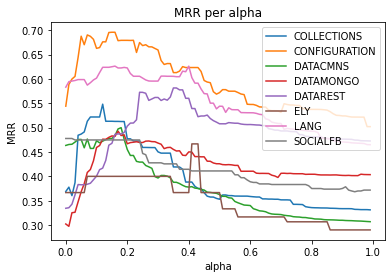

In [82]:
draw_alpha_graph(alpha_MRR, "MRR", "MRR per alpha")

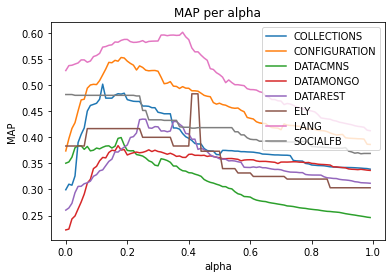

In [83]:
draw_alpha_graph(alpha_MAP, "MAP", "MAP per alpha")